In [5]:
!pip install xgboost lightgbm catboost


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape)
print(test.shape)

train.head()


(630000, 15)
(270000, 14)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [8]:
 from google.colab import files
 uploaded = files.upload()


Saving train.csv to train.csv
Saving test.csv to test.csv


In [10]:
train.isnull().sum()
test.isnull().sum()


,0
id,0
Age,0
Sex,0
Chest pain type,0
BP,0
Cholesterol,0
FBS over 120,0
EKG results,0
Max HR,0
Exercise angina,0


In [11]:
train.dtypes


,0
id,int64
Age,int64
Sex,int64
Chest pain type,int64
BP,int64
Cholesterol,int64
FBS over 120,int64
EKG results,int64
Max HR,int64
Exercise angina,int64


In [12]:
num_cols = train.select_dtypes(include=["int64","float64"]).columns
cat_cols = train.select_dtypes(include=["object"]).columns


In [13]:
for col in num_cols:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)


/tmp/ipython-input-560031510.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].median(), inplace=True)
/tmp/ipython-input-560031510.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [14]:
print(train.columns)


Index(['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol',
       'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
       'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium',
       'Heart Disease'],
      dtype='object')


In [15]:
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()


In [16]:
for col in num_cols:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(test[col].median())


In [17]:
print("Missing in train:", train.isnull().sum().sum())
print("Missing in test:", test.isnull().sum().sum())


Missing in train: 0
Missing in test: 0


In [18]:
train.duplicated().sum()


np.int64(0)

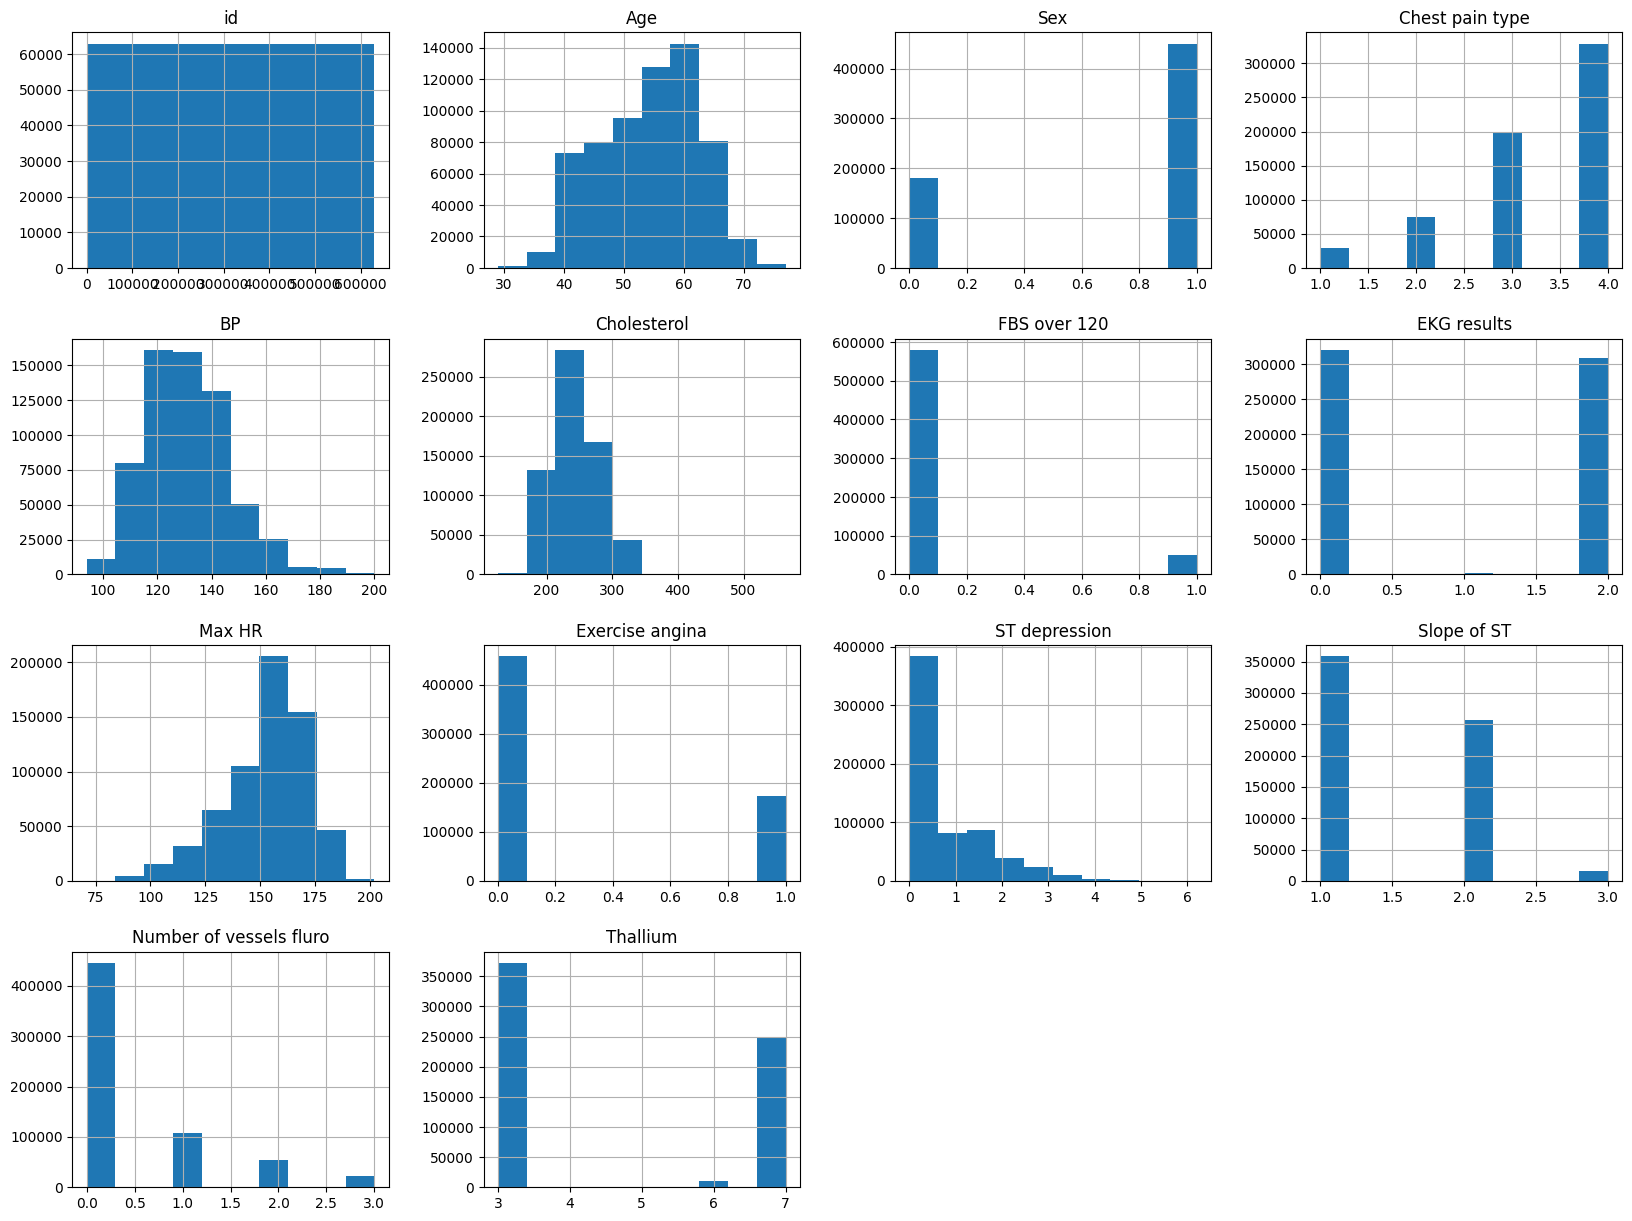

In [19]:
train.hist(figsize=(20,15))
plt.show()


In [20]:
train["Heart Disease"].value_counts()


,count
Heart Disease,
Absence,347546
Presence,282454


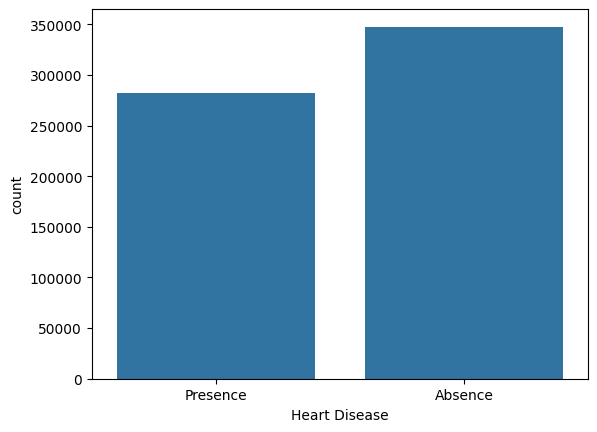

In [21]:
sns.countplot(x="Heart Disease", data=train)
plt.show()


In [22]:
X = train.drop(["Heart Disease", "id"], axis=1)
y = train["Heart Disease"]

X_test = test.drop(["id"], axis=1)


In [23]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


In [24]:
models = {

    "XGBoost": XGBClassifier(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ),

    "LightGBM": LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42
    ),

    "CatBoost": CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        verbose=0,
        random_state=42
    )
}


In [29]:
results = {}

for name, model in models.items():

    auc_scores = []
    f1_scores = []

    print(f"Training {name}...")

    for train_idx, val_idx in skf.split(X, y):

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        probs = model.predict_proba(X_val)[:,1]

        auc = roc_auc_score(y_val, probs)
        f1 = f1_score(y_val, preds)

        auc_scores.append(auc)
        f1_scores.append(f1)

    results[name] = {
        "AUC": np.mean(auc_scores),
        "F1": np.mean(f1_scores)
    }

results


Training XGBoost...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448339 -> initscore=-0.207383
[LightGBM] [Info] Start training from score -0.207383
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

{'XGBoost': {'AUC': np.float64(0.9552464389187497),
  'F1': np.float64(0.8746275305786083)},
 'LightGBM': {'AUC': np.float64(0.9551664080856247),
  'F1': np.float64(0.8746551374896361)},
 'CatBoost': {'AUC': np.float64(0.9552710010653556),
  'F1': np.float64(0.8746719344102134)}}

In [27]:
print(y.unique())


['Presence' 'Absence']


In [28]:
# Convert target to binary
y = y.map({
    "Absence": 0,
    "Presence": 1
})


In [30]:
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth":[4,6],
    "learning_rate":[0.01,0.05],
    "n_estimators":[300,500]
}

xgb = XGBClassifier(random_state=42)

grid = GridSearchCV(
    xgb,
    params,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X,y)

best_model = grid.best_estimator_


In [31]:
importance = best_model.feature_importances_

pd.DataFrame({
    "Feature":X.columns,
    "Importance":importance
}).sort_values(
    by="Importance",
    ascending=False
).head(10)


,Feature,Importance
12,Thallium,0.551782
2,Chest pain type,0.096464
8,Exercise angina,0.090410
10,Slope of ST,0.083246
11,Number of vessels fluro,0.070241
1,Sex,0.047135
9,ST depression,0.026647
6,EKG results,0.015137
7,Max HR,0.011589
0,Age,0.005537


In [32]:
best_model.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [33]:
predictions = best_model.predict_proba(X_test)[:,1]


In [34]:
submission = pd.DataFrame({
    "id":test["id"],
    "HeartDisease":predictions
})

submission.to_csv("submission.csv",index=False)


In [35]:
from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>